_Note: heainit must already be running in the terminal you run this from!_

In [11]:
from astropy.table import Table, Column
import numpy as np
import os
import subprocess
from scipy.fftpack import fftfreq
# from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator
# import matplotlib.patches as patches
# from matplotlib.collections import PatchCollection
from matplotlib.ticker import ScalarFormatter, NullFormatter
# from matplotlib.colors import cnames as mcolors
# from matplotlib._color_data import XKCD_COLORS as xkcdcolor
from xcor_tools_nicer import geom_rb, find_nearest, lin_rb
%matplotlib inline
font_prop = font_manager.FontProperties(size=20)

In [51]:
homedir = os.path.expanduser("~")
exe_dir = os.getcwd()
obj_name = "Swift_J1728.9-3613"
obj_prefix = "J1728-plateau"
n_sec = 32
int_dt = 64 # the denominator
cs_file = "%s/out/%s/%s_%dsec_%ddt_psd-cs.fits" % (exe_dir, obj_name, obj_prefix, n_sec, int_dt)
assert os.path.isfile(cs_file), "Fits file with cross spectrum does not exist."
cs_tab = Table.read(cs_file, format='fits')
print(cs_tab.info)
print(cs_tab.meta)

<Table length=2048>
   name     dtype    shape    unit                    description                  
--------- ---------- ----- --------- ----------------------------------------------
FREQUENCY    float32              Hz                              Fourier frequency
PSD_BROAD    float64       abs rms^2 PSD of all MPUs, 2.00-12.00 keV, w Poiss noise
  PSD_REF    float64       abs rms^2         Ref PSD, 3.00-12.00 keV, w Poiss noise
   PSD_CI    float64 (63,) abs rms^2                          CI PSD, w Poiss noise
    CROSS complex128 (63,)                                               CS, unnorm
    CS_B1 complex128                          CS of hard band w soft band 1, unnorm
    CS_B2 complex128                          CS of hard band w soft band 2, unnorm
    CS_B3 complex128                          CS of hard band w soft band 3, unnorm
   PSD_B1    float64       abs rms^2              PSD of soft band 1, w Poiss noise
   PSD_B2    float64       abs rms^2              PSD of

In [52]:
rebin_by = 1.11
fileroot = cs_file.replace('.fits','').replace('_cs', '')
# fit_w_noise = True
fit_w_noise = False

if fit_w_noise:
    out_file_df = fileroot+"_all-wnoise.txt"
    flx2xsp_cmd_file = fileroot+"_all-wnoise_flx2xsp.sh"
else:
    out_file_df = fileroot+"_all-nonoise.txt"
    flx2xsp_cmd_file = fileroot+"_all-nonoise_flx2xsp.sh"

n_seg = cs_tab.meta['N_SEG']
df = cs_tab.meta['DF']
dt = cs_tab.meta['DT']
n_bins = cs_tab.meta['N_BINS']
n_chans = cs_tab.meta['N_CHANS']
pos_freq = cs_tab['FREQUENCY'][0:int(n_bins/2)]
power = cs_tab['PSD_BROAD'][0:int(n_bins/2)] / cs_tab.meta['RATE_BROAD']**2
power1 = cs_tab['PSD_B1'][0:int(n_bins/2)] / cs_tab.meta['RATE_B1']**2
power2 = cs_tab['PSD_B2'][0:int(n_bins/2)] / cs_tab.meta['RATE_B2']**2
power3 = cs_tab['PSD_B3'][0:int(n_bins/2)] / cs_tab.meta['RATE_B3']**2
power4 = cs_tab['PSD_HARD'][0:int(n_bins/2)] / cs_tab.meta['RATE_HARD']**2
error = power / np.sqrt(n_seg)  ## computing it in linear re-binning
hf = int(find_nearest(pos_freq, 20)[1])
if not fit_w_noise:
    noise_level = np.mean(power[hf:int(n_bins/2)])
    power -= noise_level
    nl1 = np.mean(power1[hf:int(n_bins/2)])
    power1 -= nl1
    nl2 = np.mean(power2[hf:int(n_bins/2)])
    power2 -= nl2
    nl3 = np.mean(power3[hf:int(n_bins/2)])
    power3 -= nl3
    nl4 = np.mean(power4[hf:int(n_bins/2)])
    power4 -= nl4

In [53]:
rb_freq, rb_power, rb_err, f_min, f_max = geom_rb(pos_freq, \
                            power, error, rebin_const=rebin_by)
rb_freq, rb_power1, rb_err, f_min, f_max = geom_rb(pos_freq, \
                            power1, error, rebin_const=rebin_by)
rb_freq, rb_power2, rb_err, f_min, f_max = geom_rb(pos_freq, \
                            power2, error, rebin_const=rebin_by)
rb_freq, rb_power3, rb_err, f_min, f_max = geom_rb(pos_freq, \
                            power3, error, rebin_const=rebin_by)
rb_freq, rb_power4, rb_err, f_min, f_max = geom_rb(pos_freq, \
                            power4, error, rebin_const=rebin_by)
# rb_freq, rb_df, rb_power = lin_rb(pos_freq, power, n_bins, 512)
# rb_freq, rb_power, rb_err, f_min, f_max = geom_rb(rb_freq, \
#                             rb_power, error, rebin_const=rebin_by)
# f_bin_span = f_max - f_min
rb_fpf_psd = rb_power * rb_freq
rb_fpf_err = rb_freq * rb_err
rb_fpf_psd1 = rb_power1 * rb_freq
rb_fpf_psd2 = rb_power2 * rb_freq
rb_fpf_psd3 = rb_power3 * rb_freq
rb_fpf_psd4 = rb_power4 * rb_freq
print(len(rb_freq))
print(rb_freq[1])

45
0.03125


/anaconda3/envs/nicer/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


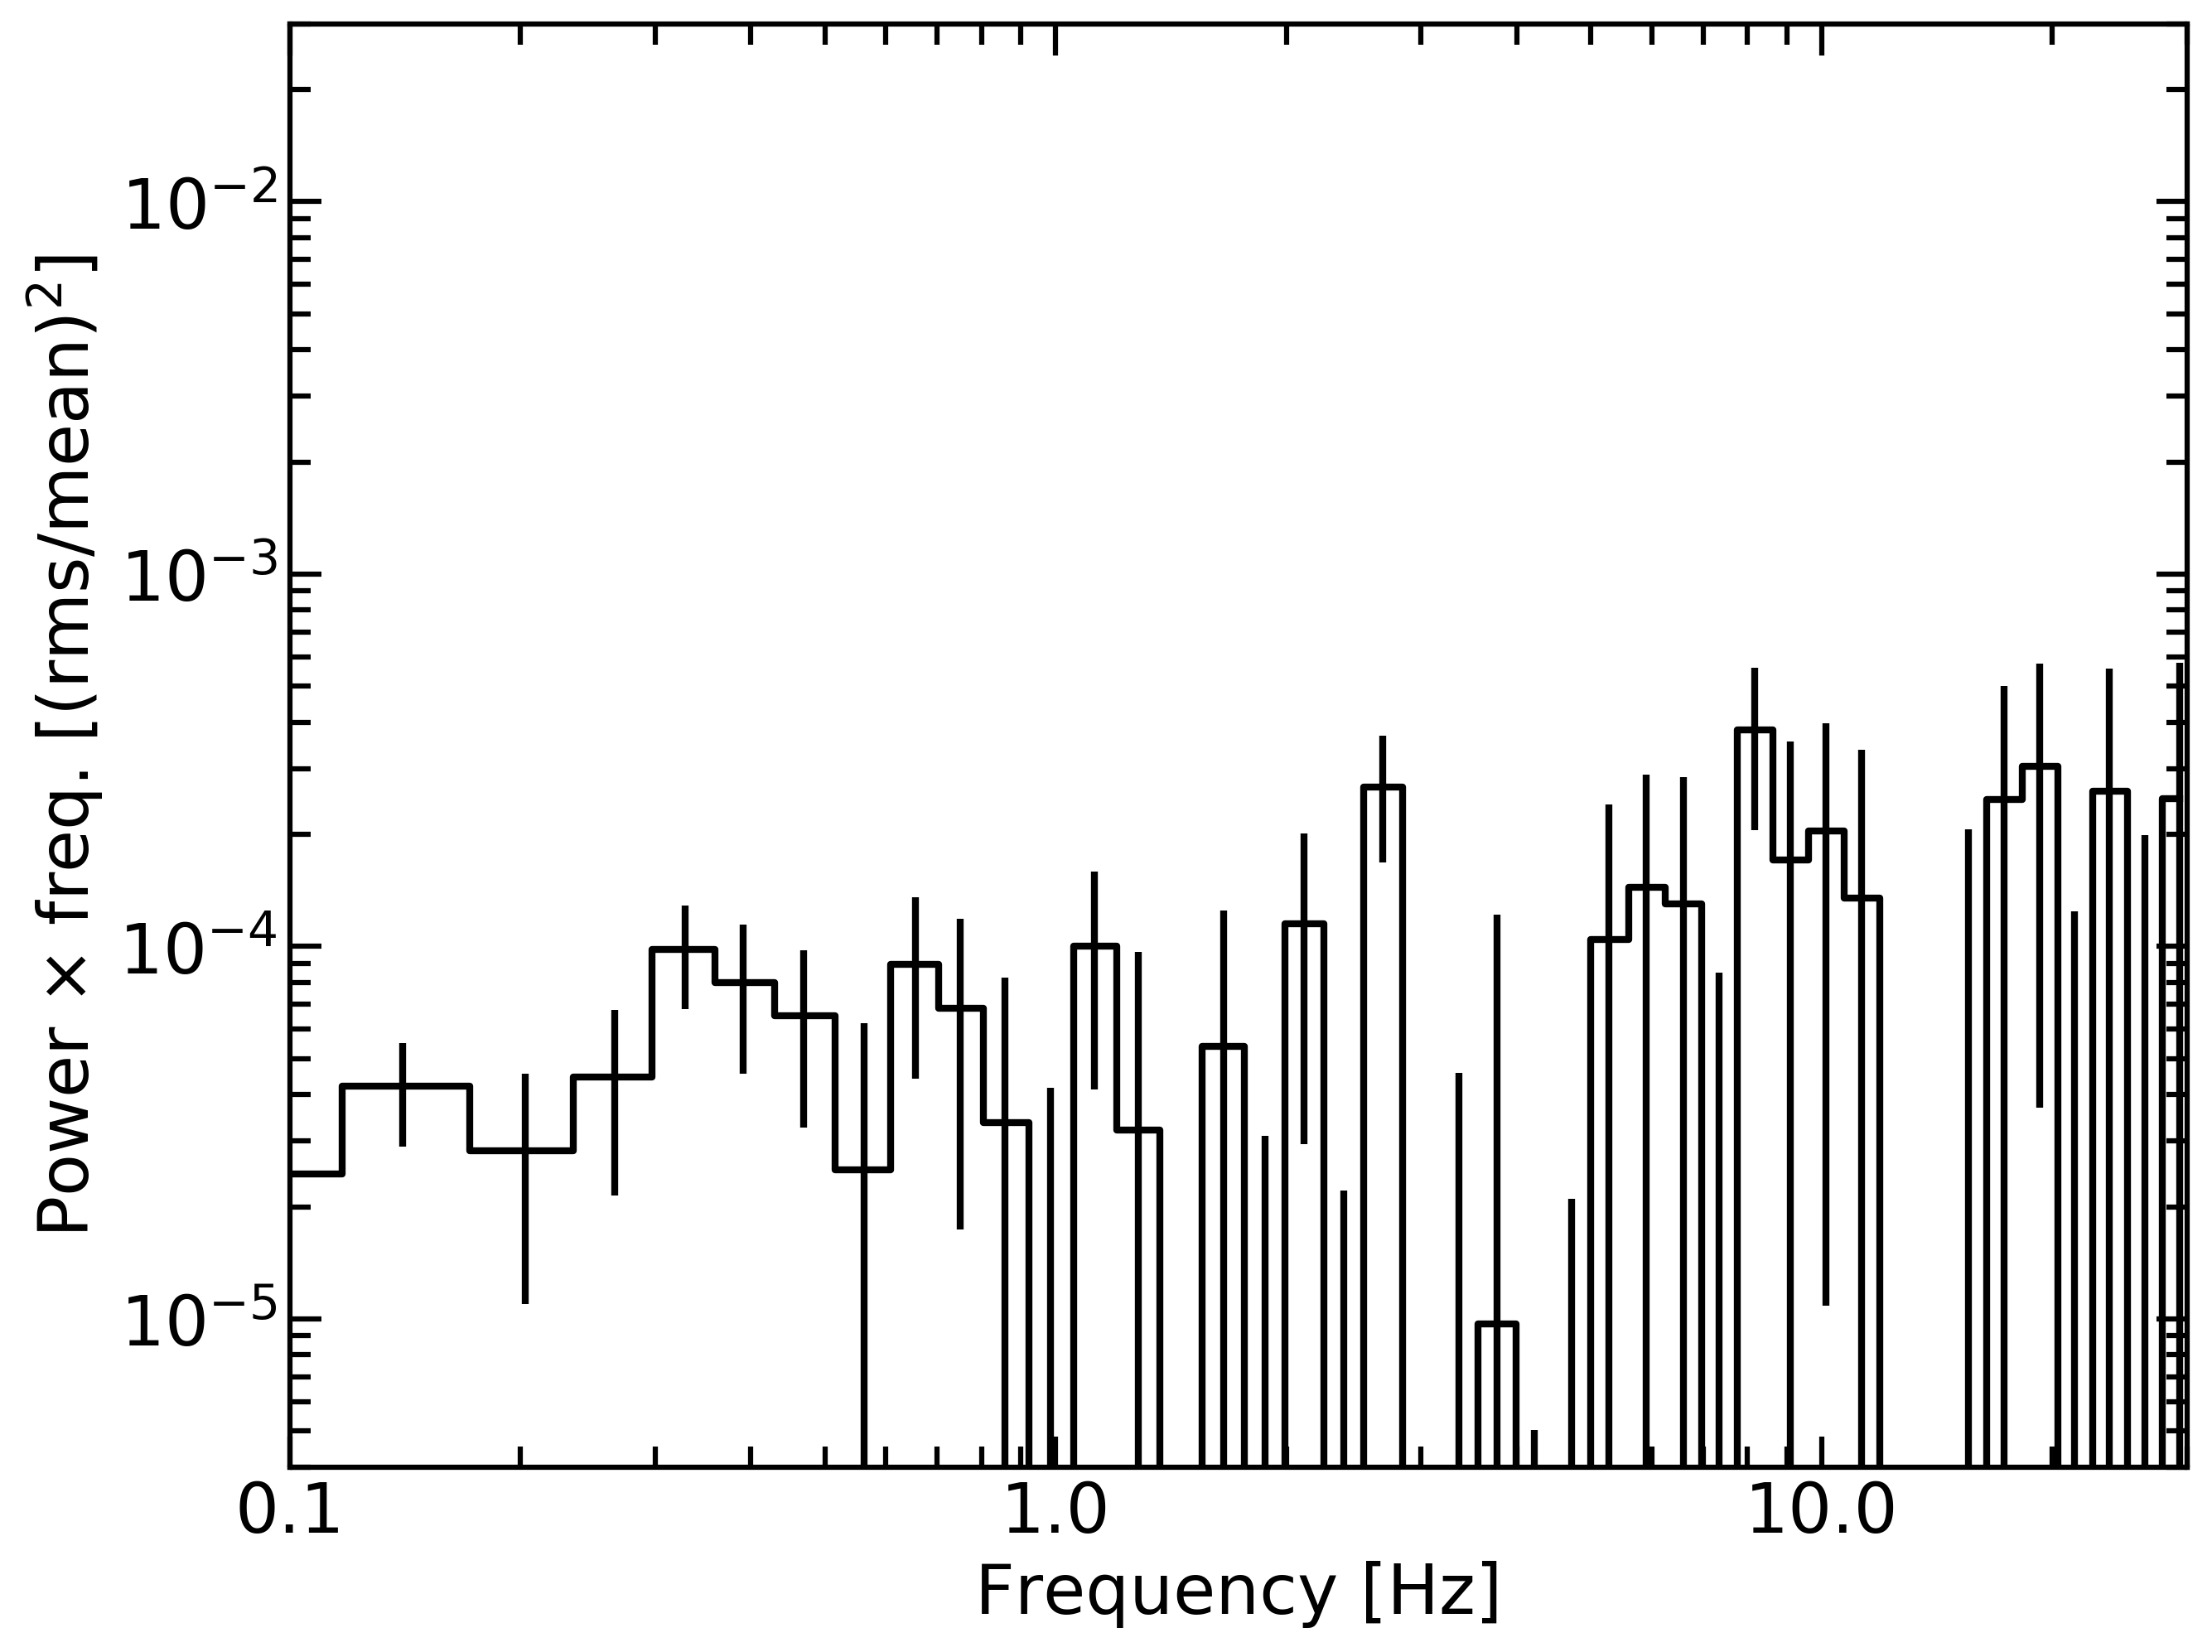

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6.75), dpi=300, tight_layout=True)
# ax.plot(rb_freq, rb_power1, lw=2, color='orange', drawstyle='steps-mid', label="0.2-1 keV", alpha=0.75)
# ax.plot(rb_freq, rb_power2, lw=2, color='blue', drawstyle='steps-mid', label="1-3 keV", alpha=0.75)
# ax.plot(rb_freq, rb_power3, lw=2, color='green', drawstyle='steps-mid', label="3-5 keV", alpha=0.75)
# ax.plot(rb_freq, rb_power4, lw=2, color='red', drawstyle='steps-mid', label="5-12 keV", alpha=0.75)
ax.errorbar(rb_freq, rb_fpf_psd, lw=2, color='black', yerr=rb_fpf_err, label="2-12 keV", 
            drawstyle='steps-mid')
# ax.plot(rb_freq, rb_fpf_psd, lw=3, color='magenta', drawstyle='steps-mid')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(8, 1024)
# ax.set_ylim(1.9, 2.1)
ax.set_xlim(.1,30)
ax.set_ylim(4e-6,0.03)
# ax.set_ylim()
# ax.set_title("2-12 keV power spectrum", fontproperties=font_prop)
ax.set_xlabel("Frequency [Hz]", fontproperties=font_prop)
# ax.set_ylabel(r"Power [(rms/mean)$^{2}$/Hz]", fontproperties=font_prop)
ax.set_ylabel(r"Power $\times$ freq. [(rms/mean)$^{2}$]", fontproperties=font_prop)
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.tick_params(axis='x', labelsize=20, bottom=True, top=True,
                labelbottom=True, labeltop=False, direction="in")
ax.tick_params(axis='y', labelsize=20, left=True, right=True,
                labelleft=True, labelright=False, direction="in")
ax.tick_params(which='major', width=1.5, length=9, direction='in')
ax.tick_params(which='minor', width=1.5, top=True, right=True, length=6, direction='in')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc=2)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
plt.savefig("./out/%s/%s_psd.eps" % (obj_name, obj_prefix))
plt.show()

In [55]:
out_tab = Table()
out_tab.meta['REBIN_BY'] = rebin_by
out_tab.meta['UNBINNED_PSD'] = cs_file
out_tab.add_column(Column(data=rb_freq, name='FREQUENCY'))
out_tab.add_column(Column(data=rb_fpf_psd, name='F P(F)'))
out_tab.write("./out/%s/%s_psd-rb.txt" % (obj_name, obj_prefix), format='ascii.commented_header', overwrite=True)

In [6]:
rebin_by = 1.1
pos_freq = cs_tab['FREQUENCY'][0:int(n_bins/2)]
# cs_amp = np.abs(cs_tab['CS_B2'][0:int(n_bins/2)])
cross = cs_tab['CS_B2'][0:int(n_bins/2)]
psd_b1 = cs_tab['PSD_B1'][0:int(n_bins/2)]
psd_b2 = cs_tab['PSD_B2'][0:int(n_bins/2)]
psd_b3 = cs_tab['PSD_B3'][0:int(n_bins/2)]
psd_hard = cs_tab['PSD_HARD'][0:int(n_bins/2)]
# rb_freq, rb_df, rb_cs_real = lin_rb(pos_freq, cross.real, n_bins, 128.)
# rb_freq, rb_df, rb_cs_imag = lin_rb(pos_freq, cross.imag, n_bins, 128.)
# new_n_bins = len(rb_freq)
# rb_cs_temp = rb_cs_real + (rb_cs_imag*1j)
# rb_freq, rb_cs, rb_err, f_min, f_max = geom_rb(rb_freq, rb_cs_temp, 
#                                                np.ones(int(n_bins/2)), 
#                                                rebin_const=rebin_by)
rb_freq, rb_psd_b2, rb_err, f_min, f_max = geom_rb(pos_freq, psd_b2, 
                                               np.ones(int(n_bins/2)), 
                                               rebin_const=rebin_by)
rb_freq, rb_psd_hard, rb_err, f_min, f_max = geom_rb(pos_freq, psd_hard, 
                                               np.ones(int(n_bins/2)), 
                                               rebin_const=rebin_by)
rb_freq, rb_cs_real, rb_err, f_min, f_max = geom_rb(pos_freq, cross.real, 
                                               np.ones(int(n_bins/2)), 
                                               rebin_const=rebin_by)
rb_freq, rb_cs_imag, rb_err, f_min, f_max = geom_rb(pos_freq, cross.imag, 
                                               np.ones(int(n_bins/2)), 
                                               rebin_const=rebin_by)
new_n_bins = len(rb_freq)
rb_cs = rb_cs_real + (rb_cs_imag*1j)
n_range = 1

# lin rb and geom rb (same way as above) the power in b2 and hard
# need to rb with the bins so I can put an array of that in for n_range
temp_2 = (np.abs(rb_cs) * (2 * dt / new_n_bins)) ** 2
powers = rb_psd_b2 * rb_psd_hard
powers[powers == 0] = 1e-14
coherence = temp_2 / powers
phase_err = np.sqrt(np.abs(1 - coherence) / \
                            (2 * coherence * n_range * n_seg))

lag = np.angle(rb_cs)

/anaconda3/envs/nicer/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


/anaconda3/envs/nicer/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


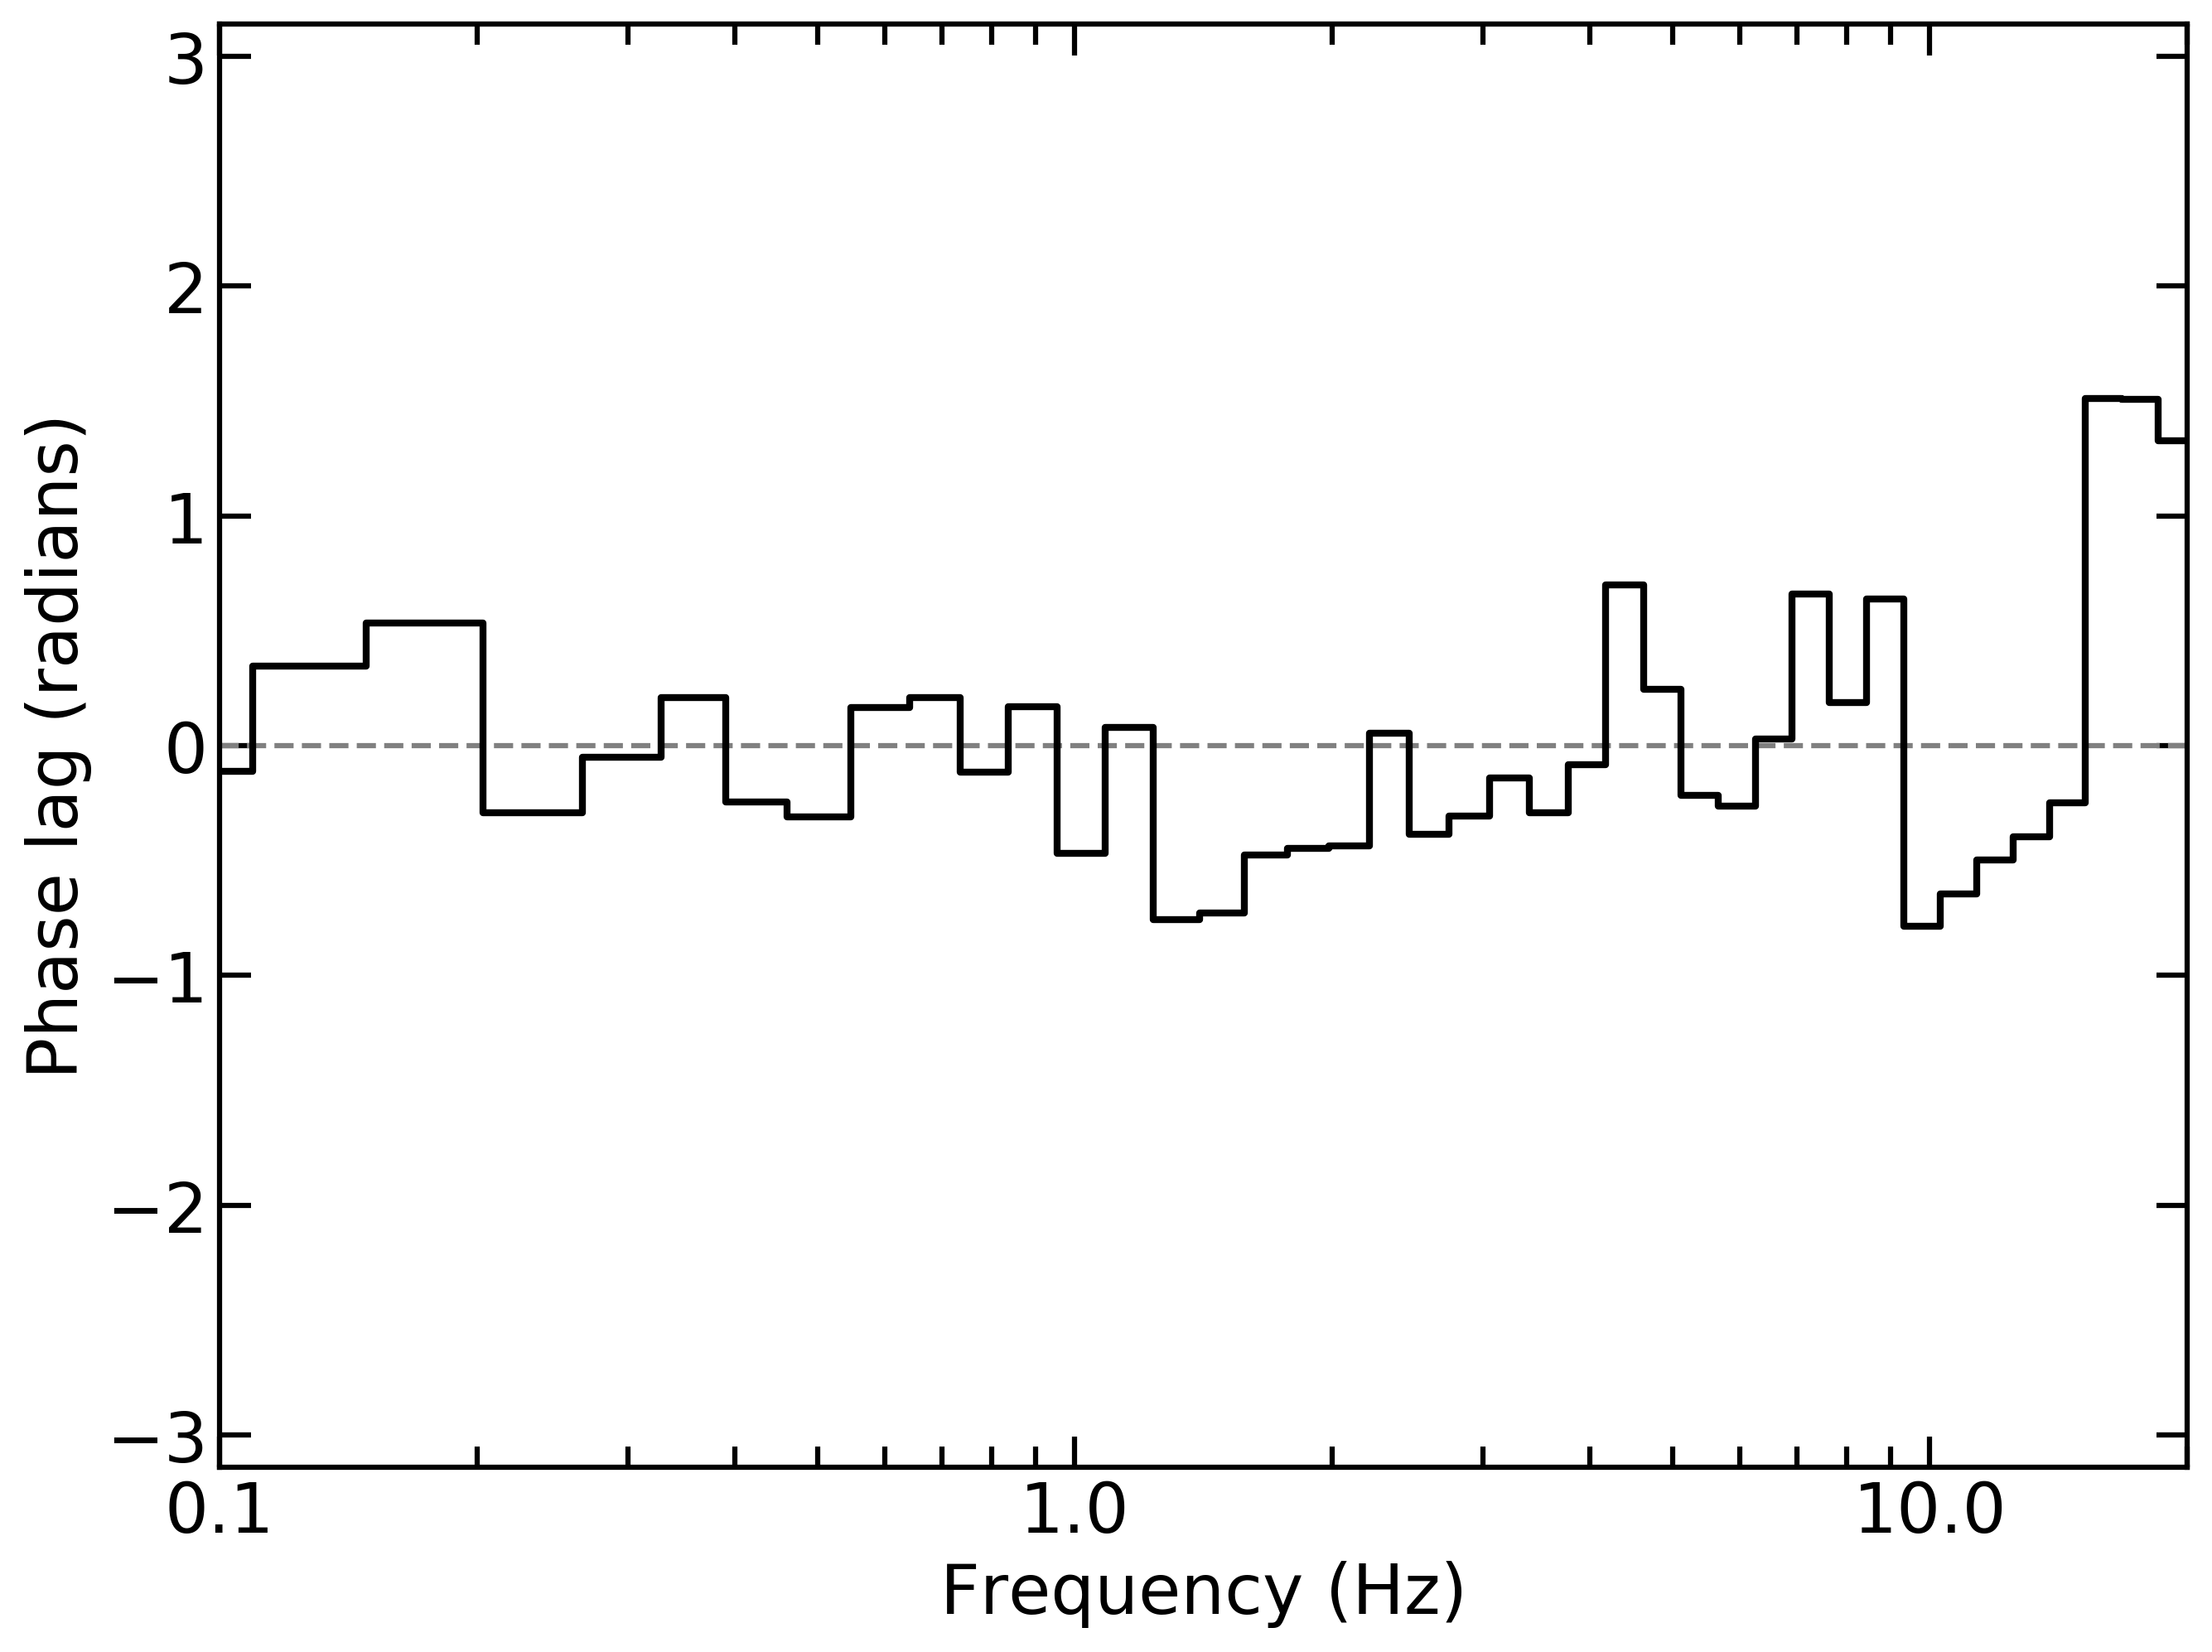

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6.75), dpi=300, tight_layout=True)
# ax.vlines(140, -3.14, 3.14, color='red', linestyle='--')
ax.hlines(0.0, 0.1, 20, color='gray', linestyle='--')
ax.plot(rb_freq, lag, lw=2, color='black', drawstyle='steps-mid')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.1, 20)
ax.set_ylim(-3.14, 3.14)
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel(r"Phase lag (radians)", fontproperties=font_prop)
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.tick_params(axis='x', labelsize=20, bottom=True, top=True,
                labelbottom=True, labeltop=False, direction="in")
ax.tick_params(axis='y', labelsize=20, left=True, right=True,
                labelleft=True, labelright=False, direction="in")
ax.tick_params(which='major', width=1.5, length=9, direction='in')
ax.tick_params(which='minor', width=1.5, top=True, right=True, length=6, direction='in')
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
# ax.set_title("Phase lag, 1-3.1 keV with 3.1-7 keV", fontproperties=font_prop)
# plt.savefig("./out/%s/%s_lag-freq.png" % (obj_name, obj_prefix))
plt.show()

In [20]:
find_nearest(rb_freq, 140)
print(lag[14])

0.8444052709673092


### Need to put power spectrum into a structure that XSPEC can work with

In [9]:
psd_df = rb_fpf_psd * f_bin_span
err_df = rb_fpf_err * f_bin_span
out_tab_df = np.vstack((f_min, f_max, psd_df, err_df))
out_tab_df = out_tab_df.T

n_psd = int((np.shape(out_tab_df)[-1]-2)/2.)
print("Number of spectra for fitting: %d" % n_psd)

Number of spectra for fitting: 1


In [10]:
np.savetxt(out_file_df, out_tab_df)
print("Saved to %s" % out_file_df)

Saved to /Users/abbie/Dropbox/Research/NICER_exploration/out/maxij1820-b_32sec_512dt_all-nonoise.txt


### Converting the power spectrum into a .pha file type for XSPEC
Need to copy-paste the printed stuff into a terminal. For some reason, flx2xsp wasn't working in subprocess.Popen.

In [11]:
basename = os.path.basename(out_file_df)[:-4]
# os.chdir("%s/out" % exe_dir)
print("heainit")
print("cd %s/out" % exe_dir)
print("flx2xsp %s.txt %s.pha %s.rsp nspec=%d clobber=yes" % (basename, basename, basename, n_psd))
# p.communicate()

heainit
cd /Users/abbie/Dropbox/Research/NICER_exploration/out
flx2xsp maxij1820-b_32sec_512dt_all-nonoise.txt maxij1820-b_32sec_512dt_all-nonoise.pha maxij1820-b_32sec_512dt_all-nonoise.rsp nspec=1 clobber=yes


### Making the XSPEC script

In [20]:
os.chdir(exe_dir)
extras= ""
xspec_fit_script = "./out/"+basename+extras+"_fitcmd.xcm"
## need +1 in these loop limits because starting at 1

with open(xspec_fit_script, mode='w') as out:
    out.write("mdefine lorf E*sigma/(2*3.14159265359)/((E-lineE)**2+((sigma/2)**2)) \n")
    out.write("data %s.pha \n" % basename)
#     out.write("ignore 1:1-2 \n")
    out.write("ignore 1:**-0.1 20.0-** \n")
    out.write("notice 1:0.1-20.0 \n")
    out.write("setplot energy \n")
#     out.write("mod pow+lorf+lorf+lorf+lorf & -1 -1 & 1e-3 1e-10 1e-10 1e-10 1e-2 1e-2 " +
    out.write("mod pow+lorf+lorf+lorf & -1 -1 & 0 -1 " +
              "&  0.509872 & 1e-22 -1 & 1e-3 1e-5 1e-5 1e-5 1e-1 1e-1" +
              "& 1.0 -1 0.1 0.1 1.5 1.5 & 3.4 -1 3.0 3.0 3.8 3.8 & 1e-3 1e-5 1e-5 1e-5 1e-1 1e-1 " + 
              "&  2.75614 & 0.477765 & 1e-3 1e-5 1e-5 1e-5 1e-1 1e-1  \n")
    out.write("chatter 4 \n")
    out.write("query no \n")
    out.write("log %s%s_fit.log \n" % (basename, extras))
    out.write("fit 1000 \n")
#     out.write("thaw 3,6,7,9,10,12,13 \n")
    out.write("thaw 6,7 \n")
#     out.write("newpar 6 =7/2. \n")
    out.write("fit 300 \n")
    out.write("newpar 0 \n")
#     out.write("chain burn 2000 \n")
#     out.write("chain walkers 1000 \n")
#     out.write("chain length 100000 \n")
#     out.write("chain run %s%s_MCMC.fits \n" % (basename, extras))
#     out.write("y \n")
#     out.write("n \n")
#     out.write("error maximum 10000. 2.706 2-14 \n")
    out.write("save all %s%s_all.xcm \n" % (basename, extras))
    out.write("y \n")
    out.write("save mod %s%s_mod.xcm \n" % (basename, extras))
    out.write("y \n")
    out.write("newpar 0 \n")
    out.write("cpd /xw \n")
    out.write("setplot delete all \n")
    out.write("iplo ufspec ratio \n")
    out.write("la T \n")
    out.write("la x Frequency (Hz) \n")
    out.write("la y Power x freq. (frac. rms\\u2\\d)\n")
    out.write("time off \n")
#     out.write("r x 0.03 128 \n")
#     out.write("r y 1e-5 0.08 \n")
    out.write("r x 0.1 20 \n")
    out.write("r y 1e-5 1e-2 \n")
    out.write("cs 1.75 \n")
    out.write("la pos y 3.0 \n")
    out.write("ma size 3 \n")
    out.write("lw 6 \n")
    out.write("lw 6 on 1,2,3,4,5,6,7,8,9,10,11,12 \n")
    out.write("co 11 on 5 \n")
    out.write("ls 1 on 5 \n")
    out.write("ls 3 on 6 \n")
    out.write("win 1 \n")
    out.write("view 0.15 0.35 0.9 0.9 \n")
    out.write("win 2 \n")
    out.write("view 0.15 0.1 0.9 0.35 \n")
#     out.write("r x 0.03 128 \n")
#     out.write("r y 0.85 1.15 \n")
    out.write("r x 0.1 20 \n")
    out.write("r y 0.5 1.5 \n")
    out.write("lw 6 \n")
    out.write("lw 6 on 1,2,3,4 \n")
    out.write("la x Frequency (Hz) \n")
    out.write("win 1 \n")
    out.write("hardcopy %s%s_fit-w-ratio.eps/cps \n" % (basename, extras))
    out.write("exit \n")
    out.write("exit \n")
print(xspec_fit_script)

./out/maxij1820-b_32sec_512dt_all-nonoise_fitcmd.xcm


### Executing the XSPEC script

In [21]:
os.chdir("%s/out" % exe_dir)
p = subprocess.Popen("xspec < %s" % (os.path.basename(xspec_fit_script)), shell=True)
p.communicate()
print("xspec < %s" % (os.path.basename(xspec_fit_script)))
print("Check log file: %s%s_fit.log" % (basename, extras))
print("And saved best-fit model file: %s%s_mod.xcm" % (basename, extras))
print("And plot: %s%s_fit-w-ratio.eps" % (basename, extras))

xspec < maxij1820-b_32sec_512dt_all-nonoise_fitcmd.xcm
Check log file: maxij1820-b_32sec_512dt_all-nonoise_fit.log
And saved best-fit model file: maxij1820-b_32sec_512dt_all-nonoise_mod.xcm
And plot: maxij1820-b_32sec_512dt_all-nonoise_fit-w-ratio.eps


### Reading in the parameter data and computing the rms (in the FWHM) of the QPO

In [49]:
class Weak_B_Pow_Model(object):
    def __init__(self, pars, n_bins=8192, dt=0.0001220703125):
        """
        Parameters
        ----------
        pars : 1-D np.array of floats
            Parameters from fitting cross spectra.
            pars[0] = power law index (from XSPEC pow mod)
            pars[1] = power law normalization (from XSPEC pow mod)
            pars[2] = BBN1 FWHM (from LORF mod )
            pars[3] = BBN1 centroid (from LORF mod)
            pars[4] = BBN1 normalization (from LORF mod)
            pars[5] = QPO FWHM (from LORF mod)
            pars[6] = QPO centroid frequency (from LORF mod)
            pars[7] = QPO normalization (from LORF mod)
            pars[8] = Harmonic FWHM (from LORF mod)
            pars[9] = Harmonic centroid frequency (from LORF mod)
            pars[10] = Harmonic normalization (from LORF mod)
            pars[11] = BBN2 FWHM (from LORF mod)
            pars[12] = BBN2 centroid frequency (from LORF mod)
            pars[13] = BBN2 normalization (from LORF mod)

        n_bins : int
            Number of bins in one Fourier transform segment (pos & neg freq).

        dt : float
            Time steps of the light curve.

        Attributes
        ----------
        pos_freq :
        qpo :
        continuum :
        qpo_filt :
        """
        self.pos_freq = np.abs(fftfreq(n_bins, d=dt)[0:int(n_bins/2+1)])
        self.pos_freq[0] = 1e-14
        powerlaw = self.__xspec_powerlaw(pars[0], pars[1])
        bbn1 = self.__lorf(pars[2], pars[3], pars[4])
        self.qpo = self.__lorf(pars[5], pars[6], pars[7])
        self.qpo /= self.pos_freq
        harmonic = self.__lorf(pars[8], pars[9], pars[10])
        bbn2 = self.__lorf(pars[11], pars[12], pars[13])
        self.continuum = powerlaw + bbn1 + bbn2 + self.qpo + harmonic
#         nf_continuum = self.continuum[1:-1]
#         whole_continuum = np.concatenate((self.continuum,
#                                           nf_continuum[::-1]), axis=0)
#         nf_qpo = self.qpo[1:-1]
#         whole_qpo = np.concatenate((self.qpo, nf_qpo[::-1]), axis=0)

#         ## This filter is multiplied by both the real and imaginary components
#         ## of the Fourier transform, in order to preserve the phase.

#         ## Avoiding divide-by-zero errors
#         whole_qpo[whole_continuum == 0] = 1e-14
#         whole_continuum[whole_continuum == 0] = 1e-14

#         ## It's an optimal filter!
#         ## The ratio here applied to the cross spectrum is the same as
#         ## the sqrt of the ratio applied to the FFT. Apply this here to the cs.
#         self.qpo_filt = whole_qpo / whole_continuum

    def __lorf(self, sigma, lineE, norm):
        """
        The lorentz function times frequency, for fitting f*P(f).
        Note that sigma here is the full width half max, and lineE is the
        centroid frequency.
        sigma :
        lineE :
        norm :

        Returns
        -------
        The Lorentzian function times frequency evaluated at every input
        frequency.
        """
        temp = norm * self.pos_freq * sigma / (2*3.14159265359) /\
              ((self.pos_freq - lineE) **2 + ((sigma / 2.) **2))
        return temp

    def __xspec_powerlaw(self, phoindex, norm):
        """
        The powerlaw function as defined by XSPEC.
        Note that phoindex is automatically made negative in here, so a negative
        phoindex input returns a positive slope!
        phoindex :
        norm :

        Returns
        -------
        The powerlaw function evaluated at every input frequency.
        norm*freq**(-phoindex)
        """
        temp = norm * self.pos_freq ** (-phoindex)
        return temp

def get_qpo_rms(psd_mod_file, n_bins, dt, df):
    """
    Reads in the parameters for the band power spectrum model to compute the 
    rms of the QPO over the FWHM range.
    Designed to read in from the '_mod.xcm' file from the 'save mod xx_mod.xcm'
    XSPEC command.
    :param psd_mod_file:
    :param n_bins:
    :param dt:
    :return:
    """
    f = open(psd_mod_file, 'r')
    f.seek(210)
    j = int(0)  # index in 'pars' array
    pars = np.zeros(14)
    pow_mod = Weak_B_Pow_Model(pars, n_bins=n_bins, dt=dt)
    for line in f:
#         print(line)
        element0 = line.split()[0]
        print(element0)
        if element0 != '=' and element0 != "newpar" and element0 != '/':
            pars[j] = element0
            j += 1
        elif str(element0) == '/':
            pars[j] = 2.85244
            j += 1
        else:
            j += 1
        if j == 14:
            pow_mod = Weak_B_Pow_Model(pars, n_bins=n_bins, dt=dt)
    lf = 0
    hf = -1
    lf_val = 4.27875
    hf_val = 7.13125
#     lf_val = pars[6] - (pars[5] / 2.)
#     hf_val = pars[6] + (pars[5] / 2.)
    lf = int(find_nearest(pow_mod.pos_freq, lf_val)[1])
    hf = int(find_nearest(pow_mod.pos_freq, hf_val)[1])
    rms = np.sqrt(np.sum(pow_mod.qpo[lf:hf] * df))
    return rms, lf_val, hf_val

In [50]:
psd_mod_file = exe_dir+"/out/MAXIJ1535_64sec_256dt_all-nonoise_mod.xcm"
assert os.path.isfile(psd_mod_file), "Psd model file does not exist: %s" % psd_mod_file
qpo_rms, lo_fwhm, hi_fwhm = get_qpo_rms(psd_mod_file, n_bins, dt, df)
print("QPO rms: %.6f" % qpo_rms)
print("FWHM: %.5f - %.5f" % (lo_fwhm, hi_fwhm))

-1
0
0.509872
1e-06
0.000145001
/
5.70505
0.000370796
3.40887
11.1882
5.63237e-05
2.75614
0.477765
0.00100958
newpar
QPO rms: 0.013603
FWHM: 4.27875 - 7.13125


#### Remember that it should only be over the FWHM range (since that's what I'm filtering on) and it should be in abs rms^2 units!